## Предобработка данных

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается построить модель многоклассовой классификации для показателя `RiskVar`. Воспользуемся другими частями датасета freMPL (1 и 2).

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [2]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [3]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,...,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,...,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,...,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,...,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,...,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1


Предобработайте данные

In [5]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0
df.Gender, GenderRef = SeriesFactorizer(df.Gender)
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Female', 1: 'Male'}
{0: 'Other', 1: 'Alone'}


In [6]:
print(list(df.SocioCateg.unique()))
print(list(df.VehAge.unique()))
print(list(df.VehUsage.unique()))
print(list(df.VehBody.unique()))
print(list(df.VehPrice.unique()))
print(list(df.VehEngine.unique()))
print(list(df.VehEnergy.unique()))
print(list(df.VehMaxSpeed.unique()))
print(list(df.VehClass.unique()))
print(list(df.Garage.unique()))

['CSP1', 'CSP55', 'CSP47', 'CSP50', 'CSP60', 'CSP48', 'CSP46', 'CSP37', 'CSP26', 'CSP42', 'CSP66', 'CSP6', 'CSP49', 'CSP51', 'CSP22', 'CSP3', 'CSP7', 'CSP73', 'CSP74', 'CSP21', 'CSP16', 'CSP77', 'CSP40', 'CSP20', 'CSP57', 'CSP5', 'CSP62', 'CSP2', 'CSP19', 'CSP65', 'CSP70', 'CSP18', 'CSP38', 'CSP61', 'CSP56', 'CSP41', 'CSP91', 'CSP32', 'CSP35', 'CSP27', 'CSP59', 'CSP43', 'CSP33', 'CSP9', 'CSP39', 'CSP28', 'CSP36', 'CSP23', 'CSP25', 'CSP30', 'CSP31', 'CSP63']
['2', '0', '1', '3', '6-7', '4', '5', '10+', '8-9']
['Professional', 'Private+trip to office', 'Private', 'Professional run']
['sedan', 'microvan', 'other microvan', 'van', 'cabriolet', 'sport utility vehicle', 'station wagon', 'coupe', 'bus']
['D ', 'K ', 'L ', 'G ', 'B ', 'M ', 'P ', 'H ', 'J ', 'C ', 'N ', 'Q ', 'I ', 'F ', 'E ', 'R ', 'V ', 'O ', 'T ', 'Z ', 'A ', 'S ', 'Y ', 'U ', 'X ', 'W ', 'Z1']
['injection', 'direct injection overpowered', 'injection overpowered', 'carburation', 'GPL', 'electric']
['regular', 'diesel', 'GPL

In [7]:
cat_feats = ['SocioCateg',
             'VehAge',
             'VehUsage',
             'VehBody',
             'VehPrice',
             'VehEngine',
             'VehEnergy',
             'VehMaxSpeed',
             'VehClass',
             'Garage']

In [8]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [9]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)

In [10]:
for cat_feat in cat_feats:        
    df = pd.concat([df, pd.get_dummies(df[cat_feat], prefix=cat_feat).astype('float64')], axis=1)

In [11]:
df = df.select_dtypes(exclude=['object'])

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Поэтому, вычтем из значений переменной `RiskVar` единицу.

In [12]:
df['RiskVar'] = df['RiskVar'] -1

Данная переменная принимает значения от 1 до 20, которые, возможно, упорядочены. Посмотрим, сколько полисов соответствуют каждому из значений `RiskVar`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [13]:
FreqCount = pd.DataFrame(df.groupby('RiskVar').count()['Exposure'].rename('Count'), columns=['Count'])
FreqCount['Freq'] = FreqCount['Count']/FreqCount['Count'].sum()

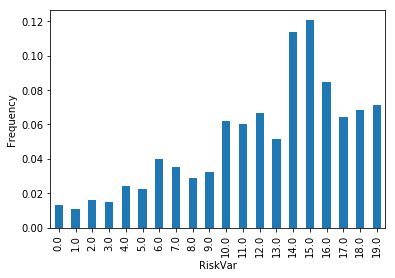

In [14]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1 (Для этого можем использовать функцию `np.where` и метод `isin` для `pandas.Series`). Также можно попробовать какой-либо другой способ задания весов.

In [15]:
df['weight'] = np.where(df['RiskVar'].isin([14,15]), 0.5, 1)
df[['RiskVar', 'weight']].head()

,RiskVar,weight
0,14.0,0.5
1,19.0,1.0
2,16.0,1.0
3,16.0,1.0
4,18.0,1.0


Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['RiskVar'], axis=1), df['RiskVar'], random_state=10, test_size=0.3)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, random_state=10, test_size=0.5)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [17]:
xgb_train = xgb.DMatrix(x_train.drop(['weight'], axis=1), y_train, weight=x_train['weight'])
xgb_valid = xgb.DMatrix(x_valid.drop(['weight'], axis=1), y_valid)
xgb_test = xgb.DMatrix(x_test.drop(['weight'], axis=1), y_test)

C:\Users\Viktor\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Viktor\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Для оптимизации гиперпараметров можно воспользоваться различными методами. Однако, в случае Hyperopt, на процесс подбора гиперпараметров может уйти немалое количество часов.

In [18]:
def objective(params):
    parameters = {
        'objective': 'multi:softmax',
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],
        'num_class': 20
    }
    
    cv_result = xgb.cv(parameters, xgb_train, num_boost_round=int(params['num_boost_round']), nfold=5, seed=0,
                       maximize=False, metrics = ["mlogloss"],
                       early_stopping_rounds=10)    
    score = cv_result['test-mlogloss-mean'][-1:].values[0]
    return score

In [19]:
space = {'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
         'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1),
        }

In [20]:
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5)

In [21]:
# best_params = space_eval(space, best)
# best_params['objective'] = 'multi:softmax'
# best_params['num_class'] = 20
# best_params

In [22]:
best_params = {}
best_params['alpha'] = 0.0684587711383774
best_params['colsample_bytree'] = 0.8386884284839105
best_params['eta'] = 0.7469458689388435
best_params['lambda'] = 0.9829846857049409
best_params['max_depth'] = 12
best_params['min_child_weight'] = 10.804591562000255
best_params['num_boost_round'] = 312.0
best_params['subsample'] = 0.9726112706555977
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = 20

Далее обучим нашу модель с оптимальными параметрами

In [23]:
progress = dict()
xgb_model = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')),
                     params=best_params, dtrain=xgb_train, maximize=False,
                     evals=[(xgb_train, "train"),(xgb_valid, "valid"), (xgb_test, "test")],
                     verbose_eval=False,
                     early_stopping_rounds=10)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [24]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_model.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.9875841750841751
F1 Score on valid: 0.29083469721767596
F1 Score on test: 0.2877250409165303


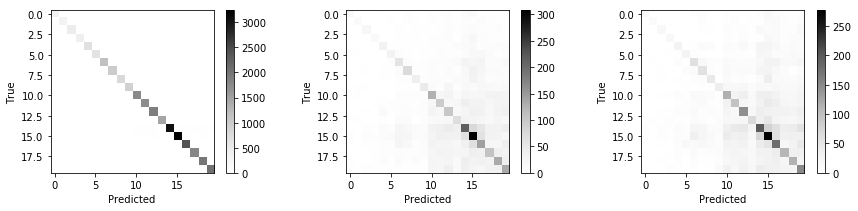

In [25]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_model.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

In [26]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify

In [27]:
def map_for_dict_Gender(Gender):
    dict_Gender = {'Male':0, 'Female':1}
    res = dict_Gender.get(Gender)
    return res

def map_for_dict_MariStat(MariStat):
    dict_MariStat = {'Other':0, 'Alone':1}
    res = dict_MariStat.get(MariStat)
    return res

def f_VehUsage_Professional(VehUsage):
    if VehUsage == 'Professional':
        VehUsage_Professional = 1
    else:
        VehUsage_Professional = 0
    return(VehUsage_Professional)

def f_VehUsage_Private_trip_to_office(VehUsage):
    if VehUsage == 'Private+trip to office':
        VehUsage_Private_trip_to_office = 1
    else:
        VehUsage_Private_trip_to_office = 0
    return(VehUsage_Private_trip_to_office)

def f_VehUsage_Private(VehUsage):
    if VehUsage == 'Private':
        VehUsage_Private = 1
    else:
        VehUsage_Private = 0
    return(VehUsage_Private)

def f_VehUsage_Professional_run(VehUsage):
    if VehUsage == 'Professional run':
        VehUsage_Professional_run = 1
    else:
        VehUsage_Professional_run = 0
    return(VehUsage_Professional_run)

def f_VehBody_sport(VehBody):
    if VehBody == 'sport utility vehicle':
        VehBody_sport = 1
    else:
        VehBody_sport = 0
    return(VehBody_sport)

def f_VehBody_stationwagon(VehBody):
    if VehBody == 'station wagon':
        VehBody_stationwagon = 1
    else:
        VehBody_stationwagon = 0
    return(VehBody_stationwagon)

def f_VehBody_bus(VehBody):
    if VehBody == 'bus':
        VehBody_bus = 1
    else:
        VehBody_bus = 0
    return(VehBody_bus)

def f_VehBody_coupe(VehBody):
    if VehBody == 'coupe':
        VehBody_coupe = 1
    else:
        VehBody_coupe = 0
    return(VehBody_coupe)

def f_VehBody_cabriolet(VehBody):
    if VehBody == 'cabriolet':
        VehBody_cabriolet = 1
    else:
        VehBody_cabriolet = 0
    return(VehBody_cabriolet)

def f_VehBody_van(VehBody):
    if VehBody == 'van':
        VehBody_van = 1
    else:
        VehBody_van = 0
    return(VehBody_van)

def f_VehBody_othermicrovan(VehBody):
    if VehBody == 'other microvan':
        VehBody_othermicrovan = 1
    else:
        VehBody_othermicrovan = 0
    return(VehBody_othermicrovan)

def f_VehBody_microvan(VehBody):
    if VehBody == 'microvan':
        VehBody_microvan = 1
    else:
        VehBody_microvan = 0
    return(VehBody_microvan)

def f_VehBody_sedan(VehBody):
    if VehBody == 'sedan':
        VehBody_sedan = 1
    else:
        VehBody_sedan = 0
    return(VehBody_sedan)

def f_VehPrice_D (VehPrice):
    if VehPrice == 'D ':
        VehPrice_D  = 1
    else:
        VehPrice_D  = 0
    return(VehPrice_D )



def f_VehPrice_K (VehPrice):
    if VehPrice == 'K ':
        VehPrice_K  = 1
    else:
        VehPrice_K  = 0
    return(VehPrice_K )



def f_VehPrice_L (VehPrice):
    if VehPrice == 'L ':
        VehPrice_L  = 1
    else:
        VehPrice_L  = 0
    return(VehPrice_L )



def f_VehPrice_G (VehPrice):
    if VehPrice == 'G ':
        VehPrice_G  = 1
    else:
        VehPrice_G  = 0
    return(VehPrice_G )



def f_VehPrice_B (VehPrice):
    if VehPrice == 'B ':
        VehPrice_B  = 1
    else:
        VehPrice_B  = 0
    return(VehPrice_B )



def f_VehPrice_M (VehPrice):
    if VehPrice == 'M ':
        VehPrice_M  = 1
    else:
        VehPrice_M  = 0
    return(VehPrice_M )



def f_VehPrice_P (VehPrice):
    if VehPrice == 'P ':
        VehPrice_P  = 1
    else:
        VehPrice_P  = 0
    return(VehPrice_P )



def f_VehPrice_H (VehPrice):
    if VehPrice == 'H ':
        VehPrice_H  = 1
    else:
        VehPrice_H  = 0
    return(VehPrice_H )



def f_VehPrice_J (VehPrice):
    if VehPrice == 'J ':
        VehPrice_J  = 1
    else:
        VehPrice_J  = 0
    return(VehPrice_J )



def f_VehPrice_C (VehPrice):
    if VehPrice == 'C ':
        VehPrice_C  = 1
    else:
        VehPrice_C  = 0
    return(VehPrice_C )



def f_VehPrice_N (VehPrice):
    if VehPrice == 'N ':
        VehPrice_N  = 1
    else:
        VehPrice_N  = 0
    return(VehPrice_N )



def f_VehPrice_Q (VehPrice):
    if VehPrice == 'Q ':
        VehPrice_Q  = 1
    else:
        VehPrice_Q  = 0
    return(VehPrice_Q )



def f_VehPrice_I (VehPrice):
    if VehPrice == 'I ':
        VehPrice_I  = 1
    else:
        VehPrice_I  = 0
    return(VehPrice_I )



def f_VehPrice_F (VehPrice):
    if VehPrice == 'F ':
        VehPrice_F  = 1
    else:
        VehPrice_F  = 0
    return(VehPrice_F )



def f_VehPrice_E (VehPrice):
    if VehPrice == 'E ':
        VehPrice_E  = 1
    else:
        VehPrice_E  = 0
    return(VehPrice_E )



def f_VehPrice_R (VehPrice):
    if VehPrice == 'R ':
        VehPrice_R  = 1
    else:
        VehPrice_R  = 0
    return(VehPrice_R )



def f_VehPrice_V (VehPrice):
    if VehPrice == 'V ':
        VehPrice_V  = 1
    else:
        VehPrice_V  = 0
    return(VehPrice_V )



def f_VehPrice_O (VehPrice):
    if VehPrice == 'O ':
        VehPrice_O  = 1
    else:
        VehPrice_O  = 0
    return(VehPrice_O )



def f_VehPrice_T (VehPrice):
    if VehPrice == 'T ':
        VehPrice_T  = 1
    else:
        VehPrice_T  = 0
    return(VehPrice_T )



def f_VehPrice_Z (VehPrice):
    if VehPrice == 'Z ':
        VehPrice_Z  = 1
    else:
        VehPrice_Z  = 0
    return(VehPrice_Z )



def f_VehPrice_A (VehPrice):
    if VehPrice == 'A ':
        VehPrice_A  = 1
    else:
        VehPrice_A  = 0
    return(VehPrice_A )



def f_VehPrice_S (VehPrice):
    if VehPrice == 'S ':
        VehPrice_S  = 1
    else:
        VehPrice_S  = 0
    return(VehPrice_S )



def f_VehPrice_Y (VehPrice):
    if VehPrice == 'Y ':
        VehPrice_Y  = 1
    else:
        VehPrice_Y  = 0
    return(VehPrice_Y )



def f_VehPrice_U (VehPrice):
    if VehPrice == 'U ':
        VehPrice_U  = 1
    else:
        VehPrice_U  = 0
    return(VehPrice_U )



def f_VehPrice_X (VehPrice):
    if VehPrice == 'X ':
        VehPrice_X  = 1
    else:
        VehPrice_X  = 0
    return(VehPrice_X )



def f_VehPrice_W (VehPrice):
    if VehPrice == 'W ':
        VehPrice_W  = 1
    else:
        VehPrice_W  = 0
    return(VehPrice_W )



def f_VehPrice_Z1(VehPrice):
    if VehPrice == 'Z1':
        VehPrice_Z1 = 1
    else:
        VehPrice_Z1 = 0
    return(VehPrice_Z1)

def f_VehEngine_injection(VehEngine):
    if VehEngine == 'injection':
        VehEngine_injection = 1
    else:
        VehEngine_injection = 0
    return(VehEngine_injection)



def f_VehEngine_directinjectionoverpowered(VehEngine):
    if VehEngine == 'direct injection overpowered':
        VehEngine_directinjectionoverpowered = 1
    else:
        VehEngine_directinjectionoverpowered = 0
    return(VehEngine_directinjectionoverpowered)



def f_VehEngine_injectionoverpowered(VehEngine):
    if VehEngine == 'injection overpowered':
        VehEngine_injectionoverpowered = 1
    else:
        VehEngine_injectionoverpowered = 0
    return(VehEngine_injectionoverpowered)



def f_VehEngine_carburation(VehEngine):
    if VehEngine == 'carburation':
        VehEngine_carburation = 1
    else:
        VehEngine_carburation = 0
    return(VehEngine_carburation)



def f_VehEngine_GPL(VehEngine):
    if VehEngine == 'GPL':
        VehEngine_GPL = 1
    else:
        VehEngine_GPL = 0
    return(VehEngine_GPL)



def f_VehEngine_electric(VehEngine):
    if VehEngine == 'electric':
        VehEngine_electric = 1
    else:
        VehEngine_electric = 0
    return(VehEngine_electric)

def f_VehEnergy_regular(VehEnergy):
    if VehEnergy == 'regular':
        VehEnergy_regular = 1
    else:
        VehEnergy_regular = 0
    return(VehEnergy_regular)



def f_VehEnergy_diesel(VehEnergy):
    if VehEnergy == 'diesel':
        VehEnergy_diesel = 1
    else:
        VehEnergy_diesel = 0
    return(VehEnergy_diesel)



def f_VehEnergy_GPL(VehEnergy):
    if VehEnergy == 'GPL':
        VehEnergy_GPL = 1
    else:
        VehEnergy_GPL = 0
    return(VehEnergy_GPL)



def f_VehEnergy_eletric(VehEnergy):
    if VehEnergy == 'eletric':
        VehEnergy_eletric = 1
    else:
        VehEnergy_eletric = 0
    return(VehEnergy_eletric)

def f_VehMaxSpeed_160(VehMaxSpeed):
    if VehMaxSpeed == '160-170 km/h':
        VehMaxSpeed_160 = 1
    else:
        VehMaxSpeed_160 = 0
    return(VehMaxSpeed_160)



def f_VehMaxSpeed_170(VehMaxSpeed):
    if VehMaxSpeed == '170-180 km/h':
        VehMaxSpeed_170 = 1
    else:
        VehMaxSpeed_170 = 0
    return(VehMaxSpeed_170)



def f_VehMaxSpeed_140(VehMaxSpeed):
    if VehMaxSpeed == '140-150 km/h':
        VehMaxSpeed_140 = 1
    else:
        VehMaxSpeed_140 = 0
    return(VehMaxSpeed_140)



def f_VehMaxSpeed_150(VehMaxSpeed):
    if VehMaxSpeed == '150-160 km/h':
        VehMaxSpeed_150 = 1
    else:
        VehMaxSpeed_150 = 0
    return(VehMaxSpeed_150)



def f_VehMaxSpeed_190(VehMaxSpeed):
    if VehMaxSpeed == '190-200 km/h':
        VehMaxSpeed_190 = 1
    else:
        VehMaxSpeed_190 = 0
    return(VehMaxSpeed_190)



def f_VehMaxSpeed_200(VehMaxSpeed):
    if VehMaxSpeed == '200-220 km/h':
        VehMaxSpeed_200 = 1
    else:
        VehMaxSpeed_200 = 0
    return(VehMaxSpeed_200)



def f_VehMaxSpeed_180(VehMaxSpeed):
    if VehMaxSpeed == '180-190 km/h':
        VehMaxSpeed_180 = 1
    else:
        VehMaxSpeed_180 = 0
    return(VehMaxSpeed_180)



def f_VehMaxSpeed_220(VehMaxSpeed):
    if VehMaxSpeed == '220+ km/h':
        VehMaxSpeed_220 = 1
    else:
        VehMaxSpeed_220 = 0
    return(VehMaxSpeed_220)



def f_VehMaxSpeed_1(VehMaxSpeed):
    if VehMaxSpeed == '1-130 km/h':
        VehMaxSpeed_1 = 1
    else:
        VehMaxSpeed_1 = 0
    return(VehMaxSpeed_1)



def f_VehMaxSpeed_130(VehMaxSpeed):
    if VehMaxSpeed == '130-140 km/h':
        VehMaxSpeed_130 = 1
    else:
        VehMaxSpeed_130 = 0
    return(VehMaxSpeed_130)
	
	
def f_VehClass_B(VehClass):
    if VehClass == 'B':
        VehClass_B = 1
    else:
        VehClass_B = 0
    return(VehClass_B)



def f_VehClass_M1(VehClass):
    if VehClass == 'M1':
        VehClass_M1 = 1
    else:
        VehClass_M1 = 0
    return(VehClass_M1)



def f_VehClass_0(VehClass):
    if VehClass == '0':
        VehClass_0 = 1
    else:
        VehClass_0 = 0
    return(VehClass_0)



def f_VehClass_A(VehClass):
    if VehClass == 'A':
        VehClass_A = 1
    else:
        VehClass_A = 0
    return(VehClass_A)



def f_VehClass_M2(VehClass):
    if VehClass == 'M2':
        VehClass_M2 = 1
    else:
        VehClass_M2 = 0
    return(VehClass_M2)



def f_VehClass_H(VehClass):
    if VehClass == 'H':
        VehClass_H = 1
    else:
        VehClass_H = 0
    return(VehClass_H)

def f_Garage_None(Garage):
    if Garage == 'None':
        Garage_None = 1
    else:
        Garage_None = 0
    return(Garage_None)



def f_Garage_Privategarage(Garage):
    if Garage == 'Private garage':
        Garage_Privategarage = 1
    else:
        Garage_Privategarage = 0
    return(Garage_Privategarage)



def f_Garage_Collectivegarage(Garage):
    if Garage == 'Collective garage':
        Garage_Collectivegarage = 1
    else:
        Garage_Collectivegarage = 0
    return(Garage_Collectivegarage)

def f_VehAge_2(VehAge):
    if VehAge == '2':
        VehAge_2 = 1
    else:
        VehAge_2 = 0
    return(VehAge_2)



def f_VehAge_0(VehAge):
    if VehAge == '0':
        VehAge_0 = 1
    else:
        VehAge_0 = 0
    return(VehAge_0)



def f_VehAge_1(VehAge):
    if VehAge == '1':
        VehAge_1 = 1
    else:
        VehAge_1 = 0
    return(VehAge_1)



def f_VehAge_3(VehAge):
    if VehAge == '3':
        VehAge_3 = 1
    else:
        VehAge_3 = 0
    return(VehAge_3)



def f_VehAge_6(VehAge):
    if VehAge == '6-7':
        VehAge_6 = 1
    else:
        VehAge_6 = 0
    return(VehAge_6)



def f_VehAge_4(VehAge):
    if VehAge == '4':
        VehAge_4 = 1
    else:
        VehAge_4 = 0
    return(VehAge_4)



def f_VehAge_5(VehAge):
    if VehAge == '5':
        VehAge_5 = 1
    else:
        VehAge_5 = 0
    return(VehAge_5)



def f_VehAge_10(VehAge):
    if VehAge == '10+':
        VehAge_10 = 1
    else:
        VehAge_10 = 0
    return(VehAge_10)



def f_VehAge_8(VehAge):
    if VehAge == '8-9':
        VehAge_8 = 1
    else:
        VehAge_8 = 0
    return(VehAge_8)
	
def f_SocioCateg_CSP1(SocioCateg):
    if SocioCateg.startswith('CSP1'):
        SocioCateg_CSP1 = 1
    else:
        SocioCateg_CSP1 = 0
    return(SocioCateg_CSP1)

def f_SocioCateg_CSP2(SocioCateg):
    if SocioCateg.startswith('CSP2'):
        SocioCateg_CSP2 = 1
    else:
        SocioCateg_CSP2 = 0
    return(SocioCateg_CSP2)

def f_SocioCateg_CSP3(SocioCateg):
    if SocioCateg.startswith('CSP3'):
        SocioCateg_CSP3 = 1
    else:
        SocioCateg_CSP3 = 0
    return(SocioCateg_CSP3)

def f_SocioCateg_CSP4(SocioCateg):
    if SocioCateg.startswith('CSP4'):
        SocioCateg_CSP4 = 1
    else:
        SocioCateg_CSP4 = 0
    return(SocioCateg_CSP4)

def f_SocioCateg_CSP5(SocioCateg):
    if SocioCateg.startswith('CSP5'):
        SocioCateg_CSP5 = 1
    else:
        SocioCateg_CSP5 = 0
    return(SocioCateg_CSP5)

def f_SocioCateg_CSP6(SocioCateg):
    if SocioCateg.startswith('CSP6'):
        SocioCateg_CSP6 = 1
    else:
        SocioCateg_CSP6 = 0
    return(SocioCateg_CSP6)

def f_SocioCateg_CSP7(SocioCateg):
    if SocioCateg.startswith('CSP7'):
        SocioCateg_CSP7 = 1
    else:
        SocioCateg_CSP7 = 0
    return(SocioCateg_CSP7)

def f_SocioCateg_CSP9(SocioCateg):
    if SocioCateg.startswith('CSP9'):
        SocioCateg_CSP9 = 1
    else:
        SocioCateg_CSP9 = 0
    return(SocioCateg_CSP9)

In [28]:
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route('/predict', methods=['GET', 'POST'])
def predict3():

    try:

        json_input = request.json
        
        req = {}        
        req['Exposure'] = json_input['Exposure']
        req['LicAge'] = json_input['LicAge']
        req['Gender'] = map_for_dict_Gender(json_input['Gender'])
        req['MariStat'] = map_for_dict_MariStat(json_input['MariStat'])
        req['DrivAge'] = json_input['DrivAge']
        req['HasKmLimit'] = json_input['HasKmLimit']
        req['BonusMalus'] = json_input['BonusMalus']
        req['ClaimAmount'] = json_input['ClaimAmount']
        req['ClaimInd'] = json_input['ClaimInd']
        req['DrivAgeSq'] = json_input['DrivAgeSq']
        
        req['SocioCateg_CSP1'] = f_SocioCateg_CSP1(json_input['SocioCateg'])
        req['SocioCateg_CSP2'] = f_SocioCateg_CSP2(json_input['SocioCateg'])
        req['SocioCateg_CSP3'] = f_SocioCateg_CSP3(json_input['SocioCateg'])
        req['SocioCateg_CSP4'] = f_SocioCateg_CSP4(json_input['SocioCateg'])
        req['SocioCateg_CSP5'] = f_SocioCateg_CSP5(json_input['SocioCateg'])
        req['SocioCateg_CSP6'] = f_SocioCateg_CSP6(json_input['SocioCateg'])
        req['SocioCateg_CSP7'] = f_SocioCateg_CSP7(json_input['SocioCateg'])
        req['SocioCateg_CSP9'] = f_SocioCateg_CSP9(json_input['SocioCateg'])
        
        req['VehAge_0'] = f_VehAge_0(json_input['VehAge'])
        req['VehAge_1'] = f_VehAge_1(json_input['VehAge'])
        req['VehAge_10+'] = f_VehAge_10(json_input['VehAge'])
        req['VehAge_2'] = f_VehAge_2(json_input['VehAge'])
        req['VehAge_3'] = f_VehAge_3(json_input['VehAge'])
        req['VehAge_4'] = f_VehAge_4(json_input['VehAge'])
        req['VehAge_5'] = f_VehAge_5(json_input['VehAge'])
        req['VehAge_6-7'] = f_VehAge_6(json_input['VehAge'])
        req['VehAge_8-9'] = f_VehAge_8(json_input['VehAge'])
        
        req['VehUsage_Private'] = f_VehUsage_Private(json_input['VehUsage'])
        req['VehUsage_Private+trip to office'] = f_VehUsage_Private_trip_to_office(json_input['VehUsage'])
        req['VehUsage_Professional'] = f_VehUsage_Professional(json_input['VehUsage'])
        req['VehUsage_Professional run'] = f_VehUsage_Professional_run(json_input['VehUsage'])
        
        req['VehBody_bus'] = f_VehBody_bus(json_input['VehBody'])
        req['VehBody_cabriolet'] = f_VehBody_cabriolet(json_input['VehBody'])
        req['VehBody_coupe'] = f_VehBody_coupe(json_input['VehBody'])
        req['VehBody_microvan'] = f_VehBody_microvan(json_input['VehBody'])
        req['VehBody_other microvan'] = f_VehBody_othermicrovan(json_input['VehBody'])
        req['VehBody_sedan'] = f_VehBody_sedan(json_input['VehBody'])
        req['VehBody_sport utility vehicle'] = f_VehBody_sport(json_input['VehBody'])
        req['VehBody_station wagon'] = f_VehBody_stationwagon(json_input['VehBody'])
        req['VehBody_van'] = f_VehBody_van(json_input['VehBody'])
        
        req['VehPrice_A '] = f_VehPrice_A(json_input['VehPrice'])
        req['VehPrice_B '] = f_VehPrice_B(json_input['VehPrice'])
        req['VehPrice_C '] = f_VehPrice_C(json_input['VehPrice'])
        req['VehPrice_D '] = f_VehPrice_D(json_input['VehPrice'])
        req['VehPrice_E '] = f_VehPrice_E(json_input['VehPrice'])
        req['VehPrice_F '] = f_VehPrice_F(json_input['VehPrice'])
        req['VehPrice_G '] = f_VehPrice_G(json_input['VehPrice'])
        req['VehPrice_H '] = f_VehPrice_H(json_input['VehPrice'])
        req['VehPrice_I '] = f_VehPrice_I(json_input['VehPrice'])
        req['VehPrice_J '] = f_VehPrice_J(json_input['VehPrice'])
        req['VehPrice_K '] = f_VehPrice_K(json_input['VehPrice'])
        req['VehPrice_L '] = f_VehPrice_L(json_input['VehPrice'])
        req['VehPrice_M '] = f_VehPrice_M(json_input['VehPrice'])
        req['VehPrice_N '] = f_VehPrice_N(json_input['VehPrice'])
        req['VehPrice_O '] = f_VehPrice_O(json_input['VehPrice'])
        req['VehPrice_P '] = f_VehPrice_P(json_input['VehPrice'])
        req['VehPrice_Q '] = f_VehPrice_Q(json_input['VehPrice'])
        req['VehPrice_R '] = f_VehPrice_R(json_input['VehPrice'])
        req['VehPrice_S '] = f_VehPrice_S(json_input['VehPrice'])
        req['VehPrice_T '] = f_VehPrice_T(json_input['VehPrice'])
        req['VehPrice_U '] = f_VehPrice_U(json_input['VehPrice'])
        req['VehPrice_V '] = f_VehPrice_V(json_input['VehPrice'])
        req['VehPrice_W '] = f_VehPrice_W(json_input['VehPrice'])
        req['VehPrice_X '] = f_VehPrice_X(json_input['VehPrice'])
        req['VehPrice_Y '] = f_VehPrice_Y(json_input['VehPrice'])
        req['VehPrice_Z '] = f_VehPrice_Z(json_input['VehPrice'])
        req['VehPrice_Z1'] = f_VehPrice_Z1(json_input['VehPrice'])
        
        req['VehEngine_GPL'] = f_VehEngine_GPL(json_input['VehEngine'])
        req['VehEngine_carburation'] = f_VehEngine_carburation(json_input['VehEngine'])
        req['VehEngine_direct injection overpowered'] = f_VehEngine_directinjectionoverpowered(json_input['VehEngine'])
        req['VehEngine_electric'] = f_VehEngine_electric(json_input['VehEngine'])
        req['VehEngine_injection'] = f_VehEngine_injection(json_input['VehEngine'])
        req['VehEngine_injection overpowered'] = f_VehEngine_injectionoverpowered(json_input['VehEngine'])
        
        req['VehEnergy_GPL'] = f_VehEnergy_GPL(json_input['VehEnergy'])
        req['VehEnergy_diesel'] = f_VehEnergy_diesel(json_input['VehEnergy'])
        req['VehEnergy_eletric'] = f_VehEnergy_eletric(json_input['VehEnergy'])
        req['VehEnergy_regular'] = f_VehEnergy_regular(json_input['VehEnergy'])
        
        req['VehMaxSpeed_1-130 km/h'] = f_VehMaxSpeed_1(json_input['VehMaxSpeed'])
        req['VehMaxSpeed_130-140 km/h'] = f_VehMaxSpeed_130(json_input['VehMaxSpeed'])
        req['VehMaxSpeed_140-150 km/h'] = f_VehMaxSpeed_140(json_input['VehMaxSpeed'])
        req['VehMaxSpeed_150-160 km/h'] = f_VehMaxSpeed_150(json_input['VehMaxSpeed'])
        req['VehMaxSpeed_160-170 km/h'] = f_VehMaxSpeed_160(json_input['VehMaxSpeed'])
        req['VehMaxSpeed_170-180 km/h'] = f_VehMaxSpeed_170(json_input['VehMaxSpeed'])
        req['VehMaxSpeed_180-190 km/h'] = f_VehMaxSpeed_180(json_input['VehMaxSpeed'])
        req['VehMaxSpeed_190-200 km/h'] = f_VehMaxSpeed_190(json_input['VehMaxSpeed'])
        req['VehMaxSpeed_200-220 km/h'] = f_VehMaxSpeed_200(json_input['VehMaxSpeed'])
        req['VehMaxSpeed_220+ km/h'] = f_VehMaxSpeed_220(json_input['VehMaxSpeed'])
        
        req['VehClass_0'] = f_VehClass_0(json_input['VehClass'])
        req['VehClass_A'] = f_VehClass_A(json_input['VehClass'])
        req['VehClass_B'] = f_VehClass_B(json_input['VehClass'])
        req['VehClass_H'] = f_VehClass_H(json_input['VehClass'])
        req['VehClass_M1'] = f_VehClass_M1(json_input['VehClass'])
        req['VehClass_M2'] = f_VehClass_M2(json_input['VehClass'])
        
        req['Garage_Collective garage'] = f_Garage_Collectivegarage(json_input['Garage'])
        req['Garage_None'] = f_Garage_None(json_input['Garage'])
        req['Garage_Private garage'] = f_Garage_Privategarage(json_input['Garage'])

        df = pd.DataFrame([req])
        prediction = xgb_model.predict(xgb.DMatrix(df))
        value = prediction[0]
        
        return jsonify({'ID': json_input['ID'], 'RiskVar': str(value)}) 
    
    except Exception as e:
        print(e)
        return "Error"

In [ ]:
if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://08c4b6ec.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [17/Feb/2020 16:04:53] "POST /predict HTTP/1.1" 200 -


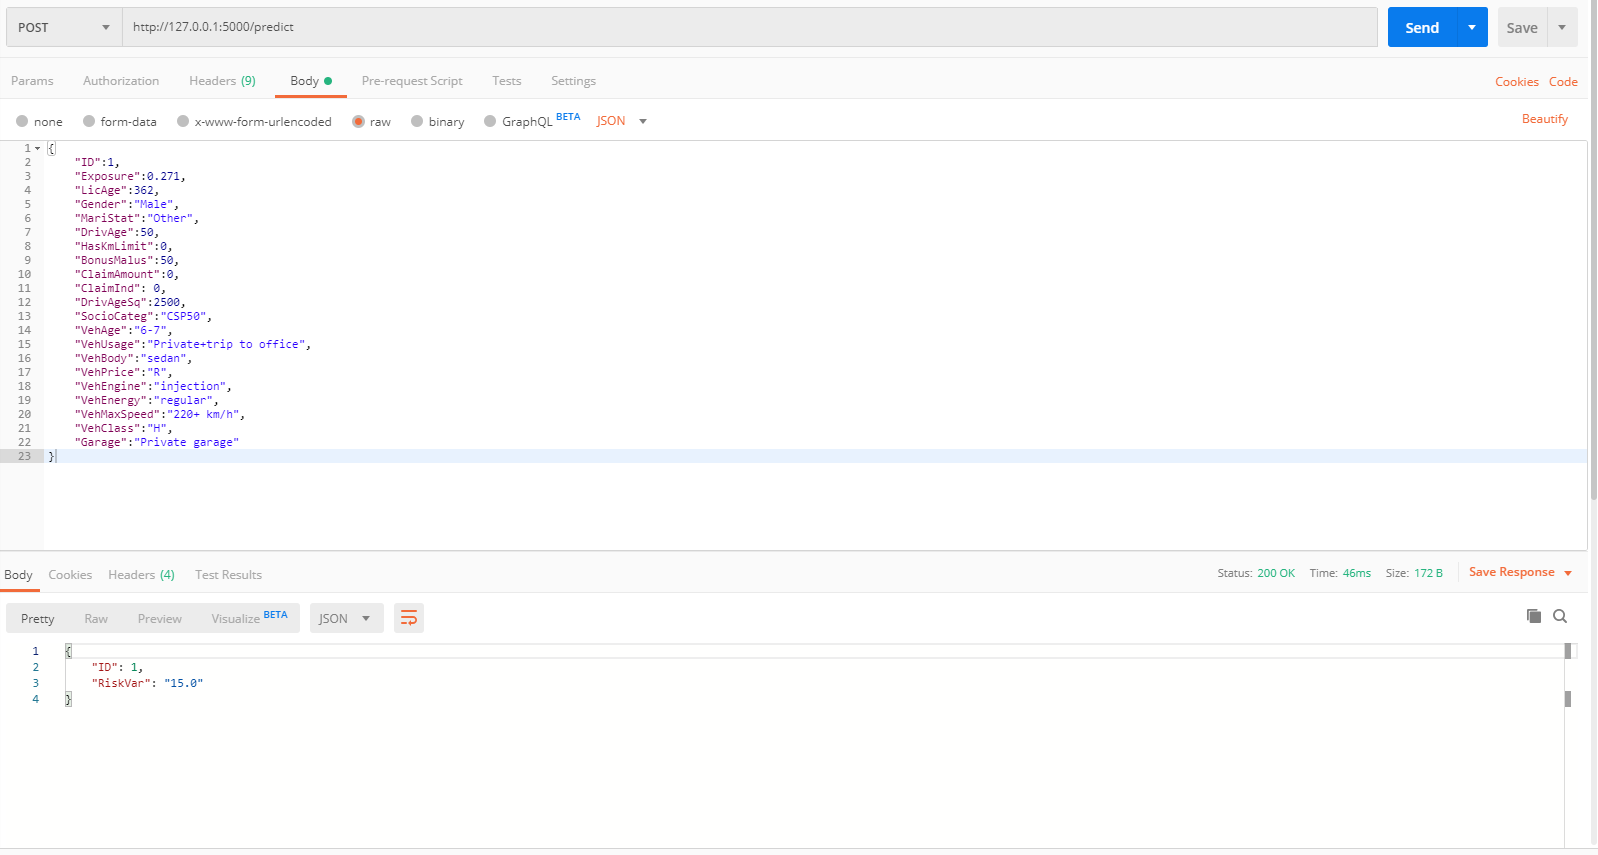